In [31]:
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from PIL import Image
import seaborn as sns
import pandas

import torch
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from learning_ai import models
from learning_ai import helpers

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Hands on with Deep Learning

Bobak Kechavarzi

# What're we going to do?

* Brief introduction - A 'quick' example
* Practice: Training and Evaluation - Convolutional Neural Net & Autoencoder

# How are we going to do it?

## Resources
* [My GitHub repo AI Tutorial](https://github.com/bdkech/ai_tutorial)
* This notebook! (Yes **[this](https://rise.readthedocs.io/en/stable/)** notebook!)
* There is even a [docker container](tbd) for local execution
## Further reading
* [Deep Learning with Python - Chollet](https://www.manning.com/books/deep-learning-with-python-second-edition?query=deep%20learning%20python)
* [Deep Learning with PyTorch - Stevens et al](https://www.manning.com/books/deep-learning-with-pytorch?query=deep%20learning%20python)
* [Deep Learning - Patterson & Gibson](https://www.oreilly.com/library/view/deep-learning/9781491924570/)
* [Deep Learning - Goodfellow](https://www.deeplearningbook.org/)

## Practice !!
* Model architecture, training helpers, and data is provided
* Play with parameters and arguments

<img src="imgs/break_things.jpg" width=60% style="margin-left:auto; margin-right:auto">

# ***Brief*** introduction


<img src="imgs/venn_diagram.png" width=60% style="margin-left:auto; margin-right:auto">

<sup>https://gist.github.com/krajiv26/839ea54316a257c1fef797deb4d13a8b</sup>

# Deep learning
- Deep learning models consist of "neurons" comprising layers
- These neurons are linear transformations, with a nonlinear function applied (**activation functions**)
    - $y = mx + b$
    - This is part of the special sauce for deep learning
- Weights are updated via **loss functions** and backpropagation
    - How accurately did the model perform during an epoch

# Some more terminology
- **Epoch** : one iteration over the whole dataset
- **Batches** : division of dataset for processing
- **Iteration** : Processing of a batch in a model

# For example ...

> If we have 1000 images and a **batch** size of 20; then each **epoch** we should have 50 **iterations**.


# Learning rates
<img src="imgs/learning_rates.png" width=60% style="margin-left:auto; margin-right:auto">

<sub>https://www.jeremyjordan.me/nn-learning-rate/</sub>

# Convolutions
<img src="imgs/convolution.gif" width=60% style="margin-left:auto; margin-right:auto">

<sup>https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1</sup>

<img src="imgs/learning_pattern.png" width=60% style="margin-left:auto; margin-right:auto">

<sub>https://www.manning.com/books/deep-learning-with-pytorch</sub>

# And now the model and training ...

## Lets make a model to classify clothing!
(And see what else we can do with it) 

# First some data

In [21]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

# Now lets set our parameters

In [24]:
# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [0.001],# our learning rates,
    batch_size = [1000],# our batch sizes,
    shuffle = [True],# do we want to shuffle?
)
epochs = 3# how many epochs?

# Our handy-dandy training loop

In [25]:
m = helpers.RunManager()

# get all runs from params using RunBuilder class
for run in helpers.RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = models.CNN()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = torch.optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
        m.begin_epoch()
        for batch in loader:
            images = batch[0]
            labels = batch[1]
            preds, embedding = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')

# Now lets see how it performs

tensor(6.7625, grad_fn=<MaxBackward1>)
Ankle boot
Ankle boot


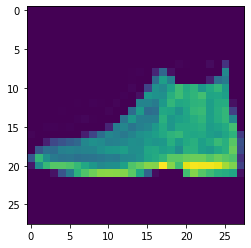

tensor(8.5906, grad_fn=<MaxBackward1>)
Pullover
Pullover


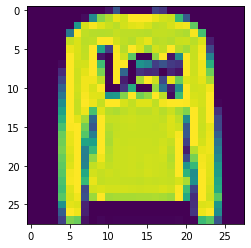

tensor(13.2911, grad_fn=<MaxBackward1>)
Trouser
Trouser


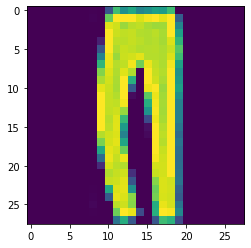

tensor(9.2462, grad_fn=<MaxBackward1>)
Trouser
Trouser


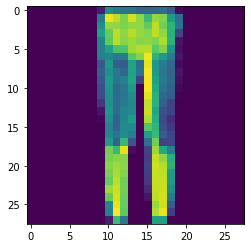

tensor(4.9311, grad_fn=<MaxBackward1>)
Pullover
Shirt


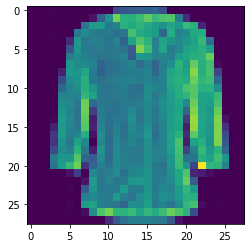

tensor(10.5868, grad_fn=<MaxBackward1>)
Trouser
Trouser


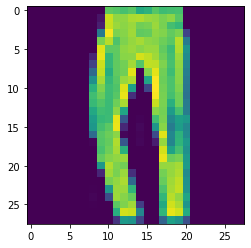

tensor(3.8693, grad_fn=<MaxBackward1>)
Pullover
Coat


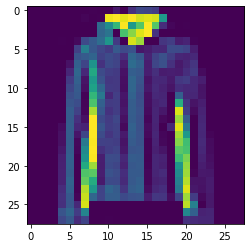

tensor(3.4609, grad_fn=<MaxBackward1>)
Pullover
Shirt


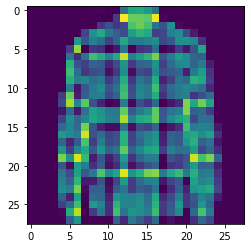

tensor(4.3810, grad_fn=<MaxBackward1>)
Sandal
Sandal


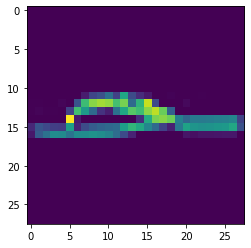

tensor(7.4133, grad_fn=<MaxBackward1>)
Sneaker
Sneaker


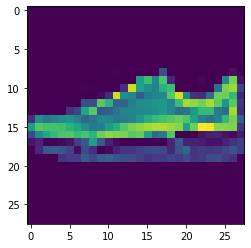

tensor(5.1684, grad_fn=<MaxBackward1>)
Coat
Coat


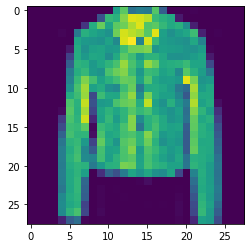

In [26]:
network.eval()
count = 0
for images, labels in test_set:
    output, embedding = network(images[None, ...])
    print(torch.max(output))
    print(test_set.classes[torch.argmax(output)])
    print(test_set.classes[labels])

    plt.figure()
    plt.imshow(images[0])
    plt.show()
    # Just for demonstration
    if count == 10:
        break
    else:
        count+=1
    

# Hmm, but what else is this good for?
<img src="imgs/thinking.png" width=60% style="margin-left:auto; margin-right:auto">


In [27]:
embeddings = []
labels = []
network.eval()
count = 0
for image, label in test_set:
    output, embedding = network(image[None, ...])
    embeddings.append(embedding.detach().numpy()[0])
    labels.append(test_set.classes[label])

In [28]:
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(embeddings)

In [29]:
reduced_embeddings_df = pandas.DataFrame(reduced_embeddings, columns=['x','y'])
reduced_embeddings_df['labels'] = labels

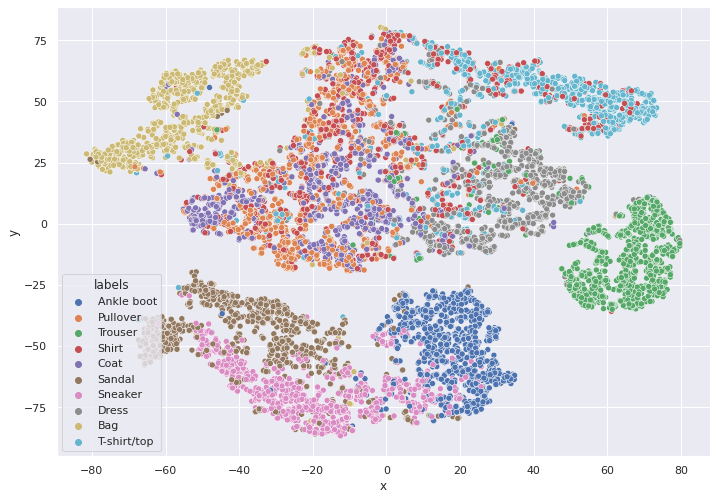

In [32]:
sns.scatterplot(data=reduced_embeddings_df, x='x', y='y', hue='labels');

# What about other models?
## Autoencoders!

In [33]:
# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [0.001],# our learning rates,
    batch_size = [1000],# our batch sizes,
    shuffle = [True],# do we want to shuffle?
)
epochs = 3# how many epochs?

In [34]:
m = helpers.RunManager()
loss_func = torch.nn.MSELoss()
# get all runs from params using RunBuilder class
for run in helpers.RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    autoencoder = models.Autoencoder()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=run.lr)

    m.begin_run(run, autoencoder, loader)
    for epoch in range(epochs):
        m.begin_epoch()
        for batch in loader:
            images = batch[0]
            preds = autoencoder(images)
            loss = loss_func(preds, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            m.track_loss(loss)
        m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results_ae')

# Lets see how it does!

In [35]:
image = Image.fromarray(preds[1][0].detach().numpy()*255)

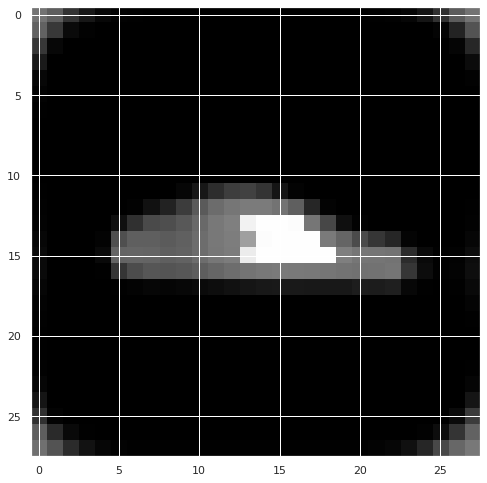

In [36]:
plt.imshow(image);

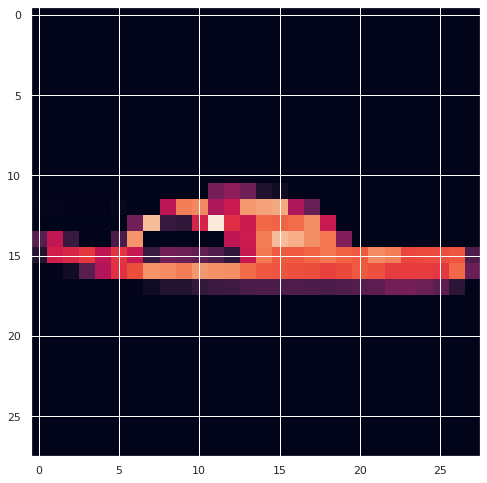

In [37]:
plt.imshow(images[1][0]);

# Oh.

# What else can we do?

# Make new data?

In [38]:
res = autoencoder.decoder(torch.rand((64,20,20)))

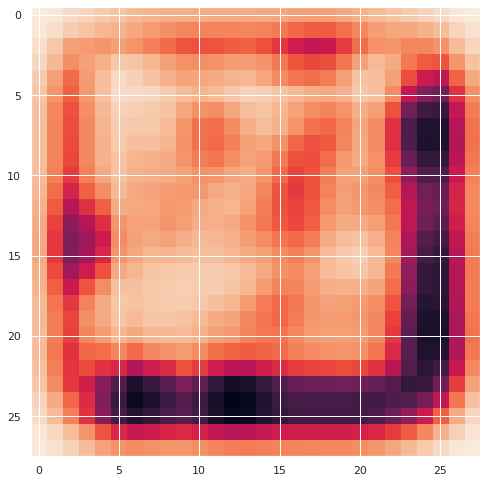

In [39]:
plt.imshow(res[0].detach().numpy()*255);